<a href="https://colab.research.google.com/github/Lohitasrith01/Sentiment-Analysis/blob/main/Senti_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import random
from nltk.corpus import wordnet
import time
import nltk
import spacy
import numpy as np
import torch
import torch.nn.utils.rnn as rnn
from collections import Counter


In [ ]:

from google.colab import files
uploaded = files.upload()

df = pd.read_csv(next(iter(uploaded)))


df.fillna("Unknown", inplace=True)


print("First 5 rows of the dataset:")
print(df.head())


num_samples = df.shape[0]


class_distribution = df["airline_sentiment"].value_counts(normalize=True) * 100


df["text_length_words"] = df["text"].apply(lambda x: len(str(x).split()))
df["text_length_chars"] = df["text"].apply(lambda x: len(str(x)))

avg_length_words = df["text_length_words"].mean()
avg_length_chars = df["text_length_chars"].mean()


unique_words = set(" ".join(df["text"].astype(str)).split())
vocab_size = len(unique_words)


print("\nDataset Statistics:")
print(f"Number of Samples: {num_samples}")
print("Class Distribution (%):")
print(class_distribution)
print(f"Average Review Length (Words): {avg_length_words:.2f}")
print(f"Average Review Length (Characters): {avg_length_chars:.2f}")
print(f"Vocabulary Size: {vocab_size}")


Saving Tweets.csv to Tweets.csv
First 5 rows of the dataset:
             tweet_id airline_sentiment  airline_sentiment_confidence  \
0  570306133677760513           neutral                        1.0000   
1  570301130888122368          positive                        0.3486   
2  570301083672813571           neutral                        0.6837   
3  570301031407624196          negative                        1.0000   
4  570300817074462722          negative                        1.0000   

  negativereason negativereason_confidence         airline  \
0        Unknown                   Unknown  Virgin America   
1        Unknown                       0.0  Virgin America   
2        Unknown                   Unknown  Virgin America   
3     Bad Flight                    0.7033  Virgin America   
4     Can't Tell                       1.0  Virgin America   

  airline_sentiment_gold        name negativereason_gold  retweet_count  \
0                Unknown     cairdin             Unk

<ipython-input-4-3492b7a664bd>:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Unknown' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("Unknown", inplace=True)


The data illustrates customer feedback tweets of some airlines, the data seems pretty biased as 62.69% of the tweets being negative, 21.17% neutral, and only 16.14% positive. The average tweet length is 17.65 words (103.82 characters), and the vocabulary size is 30,105 unique words, indicating a diverse dataset.

There are lot of missing values in dataset which needs to be handled properly. As we are implementing a sentiment analysis, we'll be only needing text and its appropriate sentiment tagging. So we can drop most of the other features like user_timezone, tweet_location, negativereasons, tweet_id. While some of the slighty useful features like airline_sentiment_gold & negativereason_gold, are almost entirely missing, so dropping them.


In [ ]:

df = pd.read_csv('Tweets.csv')[["text", "airline_sentiment", "airline_sentiment_confidence"]]
df.head()


,text,airline_sentiment,airline_sentiment_confidence
0,@VirginAmerica What @dhepburn said.,neutral,1.0000
1,@VirginAmerica plus you've added commercials t...,positive,0.3486
2,@VirginAmerica I didn't today... Must mean I n...,neutral,0.6837
3,@VirginAmerica it's really aggressive to blast...,negative,1.0000
4,@VirginAmerica and it's a really big bad thing...,negative,1.0000


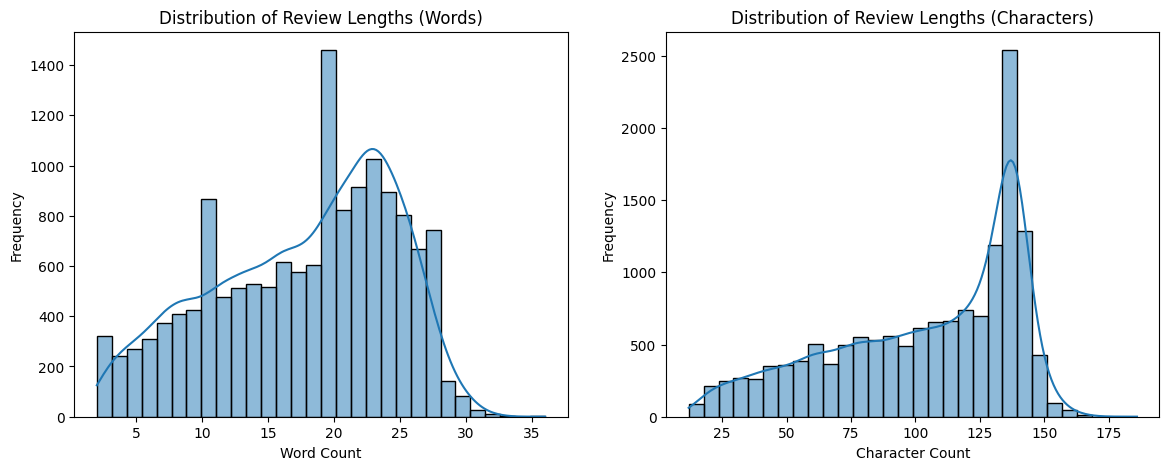

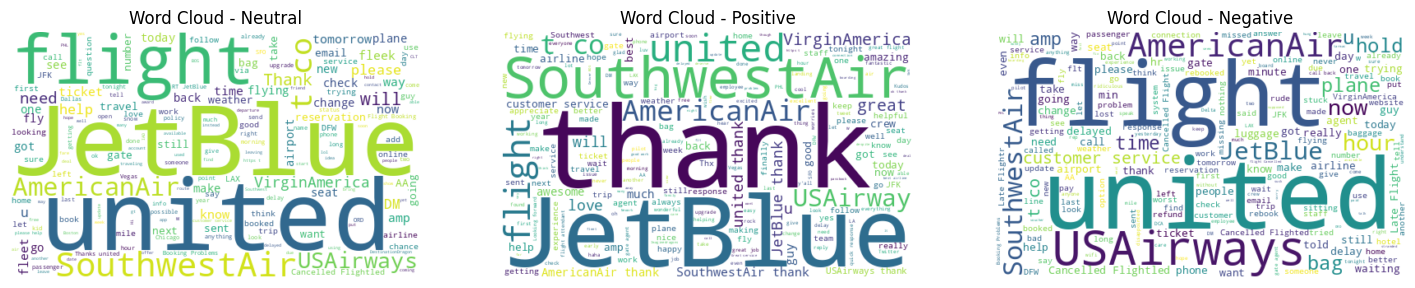

<ipython-input-6-45928a84bbb0>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="airline_sentiment", data=df, order=df["airline_sentiment"].value_counts().index, palette="viridis")


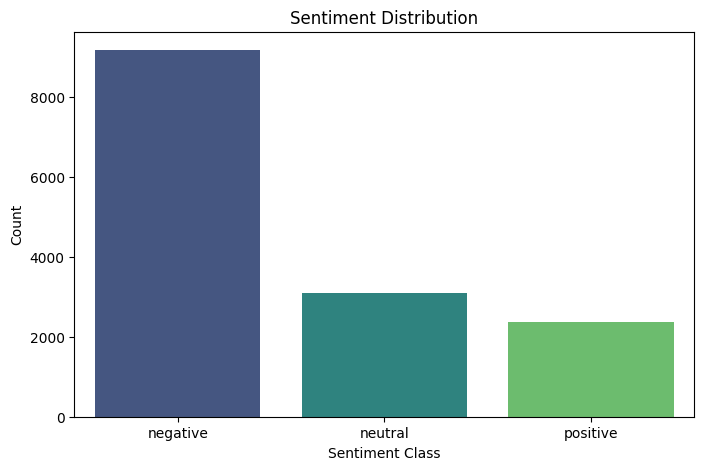

In [ ]:

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df["text"].apply(lambda x: len(str(x).split())), bins=30, kde=True, ax=axes[0])
axes[0].set_title("Distribution of Review Lengths (Words)")
axes[0].set_xlabel("Word Count")
axes[0].set_ylabel("Frequency")

sns.histplot(df["text"].apply(lambda x: len(str(x))), bins=30, kde=True, ax=axes[1])
axes[1].set_title("Distribution of Review Lengths (Characters)")
axes[1].set_xlabel("Character Count")
axes[1].set_ylabel("Frequency")

plt.show()


sentiments = df["airline_sentiment"].unique()
fig, axes = plt.subplots(1, len(sentiments), figsize=(18, 6))

for i, sentiment in enumerate(sentiments):
    text_data = " ".join(df[df["airline_sentiment"] == sentiment]["text"])
    wordcloud = WordCloud(width=500, height=300, background_color="white").generate(text_data)
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Word Cloud - {sentiment.capitalize()}")

plt.show()


plt.figure(figsize=(8, 5))
sns.countplot(x="airline_sentiment", data=df, order=df["airline_sentiment"].value_counts().index, palette="viridis")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.show()


As its clearly evident that there's a lot of class imbalance it's obvious that the model will be bias. So to deal with this I will be proceeding with data augmentation and class weighting

In [ ]:

nltk.download("wordnet")
nltk.download("omw-1.4")
def synonym_replacement(text, n=2):
    words = text.split()
    new_words = words.copy()
    random_indices = random.sample(range(len(words)), min(n, len(words)))

    for i in random_indices:
        synonyms = wordnet.synsets(words[i])
        if synonyms:
            lemmas = [lemma.name().replace("_", " ") for lemma in synonyms[0].lemmas()]
            if lemmas:
                new_words[i] = random.choice(lemmas)

    return " ".join(new_words)


def random_swap(text, n=2):
    words = text.split()
    if len(words) < 2:
        return text
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return " ".join(words)


def random_deletion(text, p=0.2):
    words = text.split()
    if len(words) == 1:
        return text
    new_words = [word for word in words if random.random() > p]
    return " ".join(new_words) if new_words else words[0]


df = pd.read_csv("Tweets.csv")[["text", "airline_sentiment"]]

# Apply augmentation to positive and neutral classes
augmented_texts = []
augmented_labels = []

for sentiment in ["positive", "neutral"]:
    subset = df[df["airline_sentiment"] == sentiment]
    for _, row in subset.iterrows():
        text = row["text"]
        augmented_texts.append(synonym_replacement(text))  # Synonym replacement
        augmented_labels.append(sentiment)

        augmented_texts.append(random_swap(text))  # Swap words
        augmented_labels.append(sentiment)

        augmented_texts.append(random_deletion(text))  # Delete words
        augmented_labels.append(sentiment)

# Createing the augmented dataset
augmented_df = pd.DataFrame({"text": augmented_texts, "airline_sentiment": augmented_labels})

# Mergeing original and augmented datasets
balanced_df = pd.concat([df, augmented_df], ignore_index=True)


balanced_df.to_csv("Augmented_Tweets.csv", index=False)

print("Data augmentation complete. Saved as 'Augmented_Tweets.csv'.")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Data augmentation complete. Saved as 'Augmented_Tweets.csv'.


First 5 rows of the dataset:
                                                text airline_sentiment
0                @VirginAmerica What @dhepburn said.           neutral
1  @VirginAmerica plus you've added commercials t...          positive
2  @VirginAmerica I didn't today... Must mean I n...           neutral
3  @VirginAmerica it's really aggressive to blast...          negative
4  @VirginAmerica and it's a really big bad thing...          negative

Class Distribution After Augmentation:
airline_sentiment
neutral     39.953587
positive    30.464771
negative    29.581641
Name: proportion, dtype: float64


<ipython-input-8-04ee6d7f43ed>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="airline_sentiment", data=df, order=df["airline_sentiment"].value_counts().index, palette="viridis")


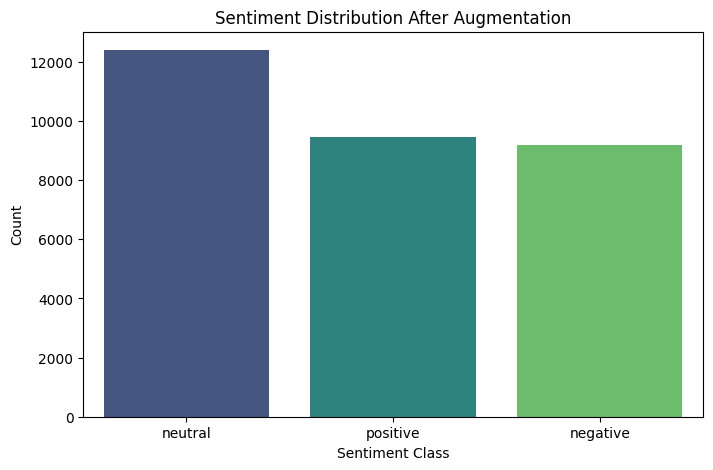

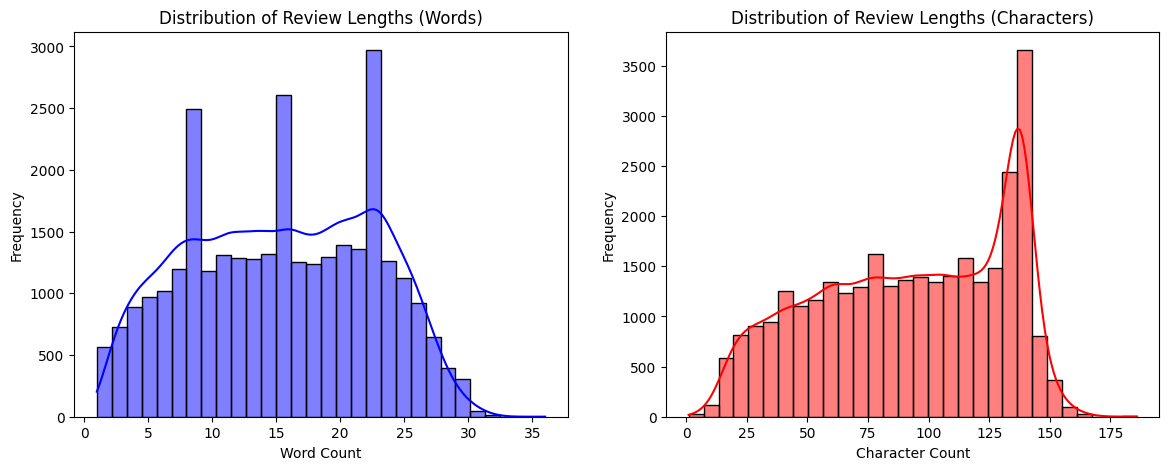

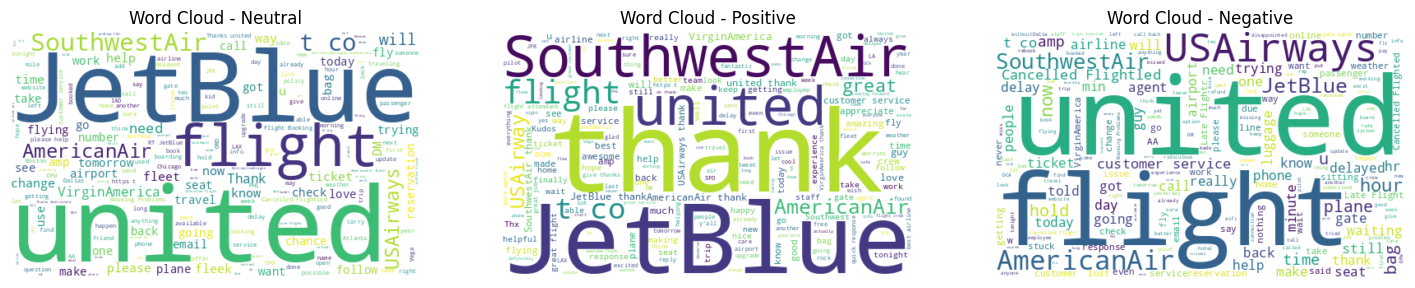

In [ ]:

file_path = "Augmented_Tweets.csv"
df = pd.read_csv(file_path)


print("First 5 rows of the dataset:")
print(df.head())


print("\nClass Distribution After Augmentation:")
class_counts = df["airline_sentiment"].value_counts(normalize=True) * 100
print(class_counts)


plt.figure(figsize=(8, 5))
sns.countplot(x="airline_sentiment", data=df, order=df["airline_sentiment"].value_counts().index, palette="viridis")
plt.title("Sentiment Distribution After Augmentation")
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df["text"].apply(lambda x: len(str(x).split())), bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribution of Review Lengths (Words)")
axes[0].set_xlabel("Word Count")
axes[0].set_ylabel("Frequency")

sns.histplot(df["text"].apply(lambda x: len(str(x))), bins=30, kde=True, ax=axes[1], color="red")
axes[1].set_title("Distribution of Review Lengths (Characters)")
axes[1].set_xlabel("Character Count")
axes[1].set_ylabel("Frequency")

plt.show()


sentiments = df["airline_sentiment"].unique()
fig, axes = plt.subplots(1, len(sentiments), figsize=(18, 6))

for i, sentiment in enumerate(sentiments):
    text_data = " ".join(df[df["airline_sentiment"] == sentiment]["text"])
    wordcloud = WordCloud(width=500, height=300, background_color="white").generate(text_data)
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Word Cloud - {sentiment.capitalize()}")

plt.show()



In [ ]:

file_path = "Augmented_Tweets.csv"
df_augmented = pd.read_csv(file_path)


class_counts = df_augmented["airline_sentiment"].value_counts()
print("Class Distribution After Augmentation:\n", class_counts)


min_count = min(class_counts["positive"], class_counts["negative"])  # Get smallest class size

# Downsample neutral class
neutral_df = df_augmented[df_augmented["airline_sentiment"] == "neutral"].sample(n=min_count, random_state=42)
positive_df = df_augmented[df_augmented["airline_sentiment"] == "positive"]
negative_df = df_augmented[df_augmented["airline_sentiment"] == "negative"]

# Combineing balanced dataset
balanced_df = pd.concat([neutral_df, positive_df, negative_df])

print("First 5 rows of Balanced Dataset:")
print(balanced_df.head())


balanced_df.to_csv("Balanced_Tweets.csv", index=False)
print("Balanced dataset saved as 'Balanced_Tweets.csv'")

Class Distribution After Augmentation:
 airline_sentiment
neutral     12396
positive     9452
negative     9178
Name: count, dtype: int64
First 5 rows of Balanced Dataset:
                                                    text airline_sentiment
9296   @USAirways while I’m asking… 2 of my 11 non up...           neutral
5327                           @SouthwestAir k thanks :)           neutral
30177  @AmericanAir yes....twice...for two different ...           neutral
27947                            Thanks! I just few DMs.           neutral
27612  @JetBlue dang. Pandora? Does it look like it m...           neutral
Balanced dataset saved as 'Balanced_Tweets.csv'


First 5 rows of the dataset:
                                                text airline_sentiment
0  @USAirways while I’m asking… 2 of my 11 non up...           neutral
1                          @SouthwestAir k thanks :)           neutral
2  @AmericanAir yes....twice...for two different ...           neutral
3                            Thanks! I just few DMs.           neutral
4  @JetBlue dang. Pandora? Does it look like it m...           neutral

Class Distribution After Downsampling:
airline_sentiment
positive    33.990219
neutral     33.004891
negative    33.004891
Name: proportion, dtype: float64


<ipython-input-10-99bba699004f>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="airline_sentiment", data=df, order=df["airline_sentiment"].value_counts().index, palette="viridis")


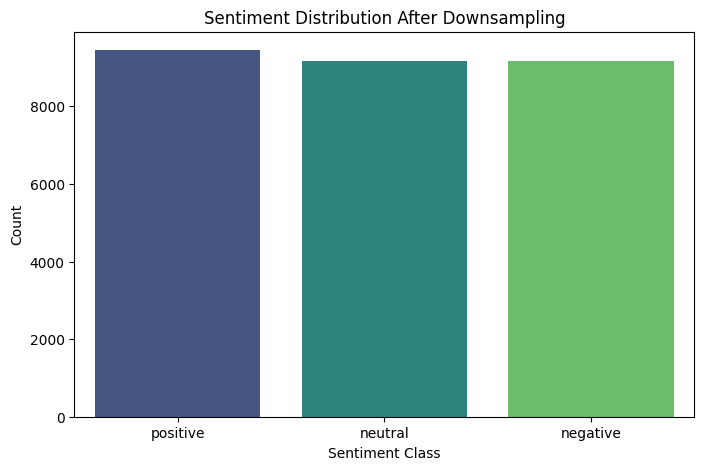

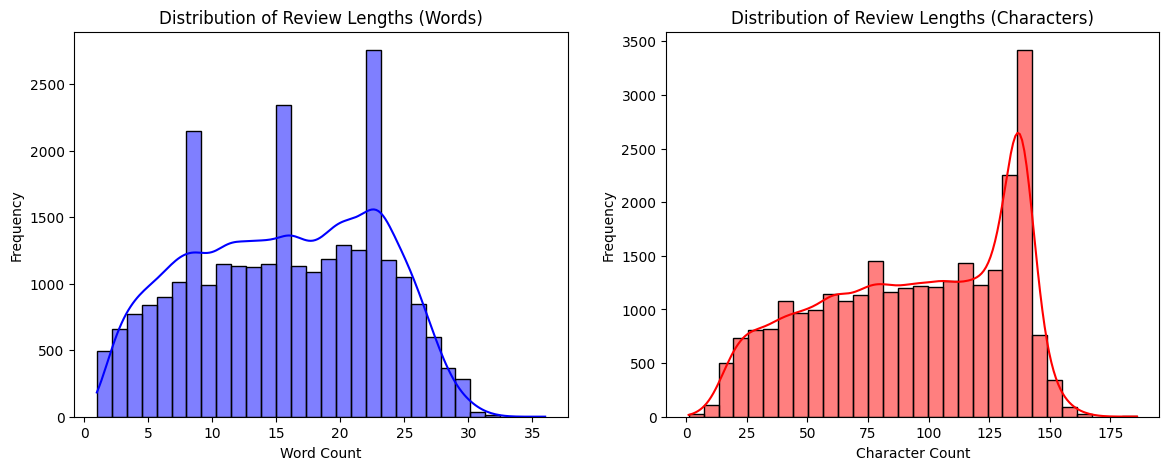

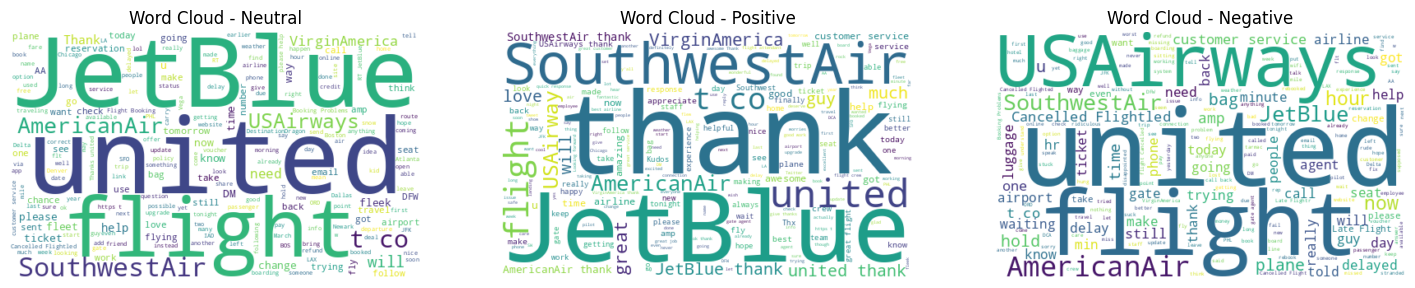

In [ ]:

file_path = "Balanced_Tweets.csv"
df = pd.read_csv(file_path)


print("First 5 rows of the dataset:")
print(df.head())

print("\nClass Distribution After Downsampling:")
class_counts = df["airline_sentiment"].value_counts(normalize=True) * 100
print(class_counts)


plt.figure(figsize=(8, 5))
sns.countplot(x="airline_sentiment", data=df, order=df["airline_sentiment"].value_counts().index, palette="viridis")
plt.title("Sentiment Distribution After Downsampling")
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df["text"].apply(lambda x: len(str(x).split())), bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribution of Review Lengths (Words)")
axes[0].set_xlabel("Word Count")
axes[0].set_ylabel("Frequency")

sns.histplot(df["text"].apply(lambda x: len(str(x))), bins=30, kde=True, ax=axes[1], color="red")
axes[1].set_title("Distribution of Review Lengths (Characters)")
axes[1].set_xlabel("Character Count")
axes[1].set_ylabel("Frequency")

plt.show()


sentiments = df["airline_sentiment"].unique()
fig, axes = plt.subplots(1, len(sentiments), figsize=(18, 6))

for i, sentiment in enumerate(sentiments):
    text_data = " ".join(df[df["airline_sentiment"] == sentiment]["text"])
    wordcloud = WordCloud(width=500, height=300, background_color="white").generate(text_data)
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(f"Word Cloud - {sentiment.capitalize()}")

plt.show()


The classes look fine now, but the customers seem to be more displeased with United in this data which can be a bit biasful

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 106.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
from nltk.tokenize import word_tokenize


nltk.download('punkt')
nltk.download('punkt_tab')

nlp = spacy.load("en_core_web_sm")


file_path = "Balanced_Tweets.csv"
df = pd.read_csv(file_path)

sample_texts = df["text"].sample(n=500, random_state=42).tolist()


nltk_tokenizer = word_tokenize
spacy_tokenizer = lambda text: [token.text for token in nlp(text)]  # SpaCy tokenization

# Tokenization with NLTK
start_time = time.time()
nltk_tokenized = [nltk_tokenizer(text) for text in sample_texts]
nltk_time = time.time() - start_time

# Tokenization with SpaCy
start_time = time.time()
spacy_tokenized = [spacy_tokenizer(text) for text in sample_texts]
spacy_time = time.time() - start_time


nltk_vocab = set(word for tweet in nltk_tokenized for word in tweet)
spacy_vocab = set(word for tweet in spacy_tokenized for word in tweet)

# comparison
print("Tokenization Comparison:")
print(f"NLTK - Vocabulary Size: {len(nltk_vocab)}, Processing Time: {nltk_time:.4f} sec")
print(f"SpaCy - Vocabulary Size: {len(spacy_vocab)}, Processing Time: {spacy_time:.4f} sec")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Tokenization Comparison:
NLTK - Vocabulary Size: 2270, Processing Time: 0.4939 sec
SpaCy - Vocabulary Size: 2274, Processing Time: 3.8004 sec


In [ ]:
from collections import Counter


nltk.download('punkt')

file_path = "Balanced_Tweets.csv"
df = pd.read_csv(file_path)


df["tokens"] = df["text"].apply(nltk.word_tokenize)

word_freq = Counter(word for tokens in df["tokens"] for word in tokens)

# Create a mapping: word → unique index
vocab = {word: idx + 2 for idx, (word, _) in enumerate(word_freq.most_common())}
# +2 because we'll reserve:
# 0 → Padding Token (PAD)
# 1 → Unknown Token (UNK)

# Add special tokens
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1


def text_to_sequence(tokens, vocab):
    return [vocab.get(word, vocab["<UNK>"]) for word in tokens]


df["sequences"] = df["tokens"].apply(lambda tokens: text_to_sequence(tokens, vocab)

print("Vocabulary Size:", len(vocab))
print("\nSample Tokenized Text:")
print(df.iloc[0]["tokens"])

print("\nSample Numerical Sequence:")
print(df.iloc[0]["sequences"])


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Vocabulary Size: 20313

Sample Tokenized Text:
['@', 'USAirways', 'while', 'I', '’', 'm', 'asking…', '2', 'of', 'my', '11', 'non', 'upgraded', 'flights', ',', 'Attendants', 'came', '&', 'amp', ';', 'greeted', 'me', '&', 'amp', ';', 'thanked', 'me', 'for', 'my', 'business', 'b/c', 'I', 'was', 'Exec', 'Plat', '.']

Sample Numerical Sequence:
[2, 23, 467, 6, 270, 1196, 12715, 87, 27, 20, 997, 1109, 1128, 71, 10, 10707, 998, 59, 68, 46, 12716, 28, 59, 68, 46, 4898, 28, 12, 20, 387, 1373, 6, 32, 3891, 3892, 3]


In [ ]:



sequence_lengths = df["sequences"].apply(len)
max_length = int(np.percentile(sequence_lengths, 95))  # 95th percentile

print(f"Chosen max_length (95th percentile): {max_length}")


tensor_sequences = [torch.tensor(seq, dtype=torch.long) for seq in df["sequences"]]


padded_sequences = rnn.pad_sequence(tensor_sequences, batch_first=True, padding_value=0)


def pad_sequence(seq, max_length, pad_value=0):
    if len(seq) < max_length:
        return seq + [pad_value] * (max_length - len(seq))
    else:
        return seq[:max_length]

df["padded_sequences"] = df["sequences"].apply(lambda seq: pad_sequence(seq, max_length))


print("\nSample Original Sequence:", df.iloc[0]["sequences"])
print("Sample Padded Sequence:", df.iloc[0]["padded_sequences"])
print("\nPadded Shape:", padded_sequences.shape)


Chosen max_length (95th percentile): 32

Sample Original Sequence: [2, 23, 467, 6, 270, 1196, 12715, 87, 27, 20, 997, 1109, 1128, 71, 10, 10707, 998, 59, 68, 46, 12716, 28, 59, 68, 46, 4898, 28, 12, 20, 387, 1373, 6, 32, 3891, 3892, 3]
Sample Padded Sequence: [2, 23, 467, 6, 270, 1196, 12715, 87, 27, 20, 997, 1109, 1128, 71, 10, 10707, 998, 59, 68, 46, 12716, 28, 59, 68, 46, 4898, 28, 12, 20, 387, 1373, 6]

Padded Shape: torch.Size([27808, 48])


This suggests some sequences still exceed 32 tokens. We might need to use max_length=47 instead if we want less truncation.

In [ ]:

max_length = 42
print(f"Updated max_length: {max_length}")


def pad_sequence(seq, max_length, pad_value=0):
    if len(seq) < max_length:
        return seq + [pad_value] * (max_length - len(seq))
    else:
        return seq[:max_length]


df["padded_sequences"] = df["sequences"].apply(lambda seq: pad_sequence(seq, max_length))


import torch.nn.utils.rnn as rnn
import torch

tensor_sequences = [torch.tensor(seq, dtype=torch.long) for seq in df["padded_sequences"]]
padded_sequences = rnn.pad_sequence(tensor_sequences, batch_first=True, padding_value=0)


print("\nSample Padded Sequence:", df.iloc[0]["padded_sequences"])
print("\nPadded Tensor Shape:", padded_sequences.shape)


Updated max_length: 42

Sample Padded Sequence: [2, 23, 467, 6, 270, 1196, 12715, 87, 27, 20, 997, 1109, 1128, 71, 10, 10707, 998, 59, 68, 46, 12716, 28, 59, 68, 46, 4898, 28, 12, 20, 387, 1373, 6, 32, 3891, 3892, 3, 0, 0, 0, 0, 0, 0]

Padded Tensor Shape: torch.Size([27808, 42])


In [ ]:
from sklearn.model_selection import train_test_split
import torch

sentiment_mapping = {"negative": 0, "neutral": 1, "positive": 2}
df["sentiment_label"] = df["airline_sentiment"].map(sentiment_mapping)


X = torch.tensor(df["padded_sequences"].tolist(), dtype=torch.long)
y = torch.tensor(df["sentiment_label"].values, dtype=torch.long)


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


print(f"Training Data: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation Data: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test Data: {X_test.shape}, Labels: {y_test.shape}")



Training Data: torch.Size([19465, 42]), Labels: torch.Size([19465])
Validation Data: torch.Size([4171, 42]), Labels: torch.Size([4171])
Test Data: torch.Size([4172, 42]), Labels: torch.Size([4172])


In [ ]:
!pip install torchinfo

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary


class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, lstm_layers, dropout, output_dim):
        super(SentimentLSTM, self).__init__()


        self.embedding = nn.Embedding(vocab_size, embedding_dim)


        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=lstm_layers,
            dropout=dropout,
            batch_first=True
        )


        self.fc = nn.Linear(hidden_dim, output_dim)


        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        last_hidden = lstm_out[:, -1, :]
        out = self.fc(last_hidden)
        return self.softmax(out)


VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
LSTM_LAYERS = 3
DROPOUT = 0.3
OUTPUT_DIM = 3


model = SentimentLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, LSTM_LAYERS, DROPOUT, OUTPUT_DIM)

summary(model, input_size=(32, 42), dtypes=[torch.long])


Layer (type:depth-idx)                   Output Shape              Param #
SentimentLSTM                            [32, 3]                   --
├─Embedding: 1-1                         [32, 42, 100]             2,031,300
├─LSTM: 1-2                              [32, 42, 128]             381,952
├─Linear: 1-3                            [32, 3]                   387
├─Softmax: 1-4                           [32, 3]                   --
Total params: 2,413,639
Trainable params: 2,413,639
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 578.36
Input size (MB): 0.01
Forward/backward pass size (MB): 2.45
Params size (MB): 9.65
Estimated Total Size (MB): 12.12

In [ ]:
import torch.optim as optim


criterion = nn.CrossEntropyLoss()


learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


model.to(device)


def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / len(X_train))


        model.eval()
        val_loss, correct_val = 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                correct_val += (outputs.argmax(1) == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / len(X_val))

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


num_epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


Using device: cuda
Epoch 1/20 - Train Loss: 1.0953, Val Loss: 1.0987, Train Acc: 0.3549, Val Acc: 0.3309
Epoch 2/20 - Train Loss: 1.0288, Val Loss: 0.9894, Train Acc: 0.4608, Val Acc: 0.5073
Epoch 3/20 - Train Loss: 0.9589, Val Loss: 0.9305, Train Acc: 0.5511, Val Acc: 0.6023
Epoch 4/20 - Train Loss: 0.8910, Val Loss: 0.9109, Train Acc: 0.6514, Val Acc: 0.6322
Epoch 5/20 - Train Loss: 0.8864, Val Loss: 0.8735, Train Acc: 0.6610, Val Acc: 0.6718
Epoch 6/20 - Train Loss: 0.9465, Val Loss: 0.9381, Train Acc: 0.5940, Val Acc: 0.6001
Epoch 7/20 - Train Loss: 0.8270, Val Loss: 0.8418, Train Acc: 0.7194, Val Acc: 0.7018
Epoch 8/20 - Train Loss: 0.7782, Val Loss: 0.8255, Train Acc: 0.7686, Val Acc: 0.7195
Epoch 9/20 - Train Loss: 0.7468, Val Loss: 0.8264, Train Acc: 0.8014, Val Acc: 0.7137
Epoch 10/20 - Train Loss: 0.7382, Val Loss: 0.7892, Train Acc: 0.8111, Val Acc: 0.7562
Epoch 11/20 - Train Loss: 0.7261, Val Loss: 0.7804, Train Acc: 0.8243, Val Acc: 0.7655
Epoch 12/20 - Train Loss: 0.7159,

It's evedient that model seems to suffer with variance, and hence overfitting. Which means we would need a better architecture but befoe that lets fine tune a bit.

In [ ]:

manual_search_params = [
    {"lr": 0.001, "batch_size": 64, "hidden_dim": 128, "dropout": 0.3, "epochs": 25},
    {"lr": 0.0001, "batch_size": 64, "hidden_dim": 256, "dropout": 0.3, "epochs": 20},
    {"lr": 0.001, "batch_size": 32, "hidden_dim": 128, "dropout": 0.2, "epochs": 25},
]

best_val_acc = 0
best_params = None

for params in manual_search_params:
    print(f"\n Testing: {params}")


    model = SentimentLSTM(VOCAB_SIZE, EMBEDDING_DIM, params["hidden_dim"], LSTM_LAYERS, params["dropout"], OUTPUT_DIM).to(device)


    optimizer = optim.Adam(model.parameters(), lr=params["lr"])
    criterion = nn.CrossEntropyLoss()


    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=params["batch_size"], shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=params["batch_size"], shuffle=False)


    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, params["epochs"]
    )


    max_val_acc = max(val_accuracies)
    print(f" Best Validation Accuracy: {max_val_acc:.4f}")


    if max_val_acc > best_val_acc:
        best_val_acc = max_val_acc
        best_params = params
        best_model = model

print("\n Best Hyperparameters Found from Manual Search:", best_params)



 Testing: {'lr': 0.001, 'batch_size': 64, 'hidden_dim': 128, 'dropout': 0.3, 'epochs': 25}
Epoch 1/25 - Train Loss: 1.0340, Val Loss: 1.0699, Train Acc: 0.4605, Val Acc: 0.4246
Epoch 2/25 - Train Loss: 1.0639, Val Loss: 1.0278, Train Acc: 0.4272, Val Acc: 0.4407
Epoch 3/25 - Train Loss: 0.9600, Val Loss: 0.9142, Train Acc: 0.5662, Val Acc: 0.6253
Epoch 4/25 - Train Loss: 0.8737, Val Loss: 0.8585, Train Acc: 0.6687, Val Acc: 0.6869
Epoch 5/25 - Train Loss: 0.8150, Val Loss: 0.8325, Train Acc: 0.7319, Val Acc: 0.7140
Epoch 6/25 - Train Loss: 0.7837, Val Loss: 0.8075, Train Acc: 0.7636, Val Acc: 0.7372
Epoch 7/25 - Train Loss: 0.7505, Val Loss: 0.7897, Train Acc: 0.7977, Val Acc: 0.7595
Epoch 8/25 - Train Loss: 0.7305, Val Loss: 0.7785, Train Acc: 0.8188, Val Acc: 0.7686
Epoch 9/25 - Train Loss: 0.7183, Val Loss: 0.7721, Train Acc: 0.8316, Val Acc: 0.7780
Epoch 10/25 - Train Loss: 0.7057, Val Loss: 0.7580, Train Acc: 0.8430, Val Acc: 0.7905
Epoch 11/25 - Train Loss: 0.6974, Val Loss: 0.7

In [ ]:

best_params_tweaked = {
    "lr": 0.001,
    "batch_size": 64,
    "hidden_dim": 128,
    "dropout": 0.15,
    "epochs": 25
}

print(f"\n Testing Final Tweaked Model: {best_params_tweaked}")


model = SentimentLSTM(VOCAB_SIZE, EMBEDDING_DIM, best_params_tweaked["hidden_dim"], LSTM_LAYERS, best_params_tweaked["dropout"], OUTPUT_DIM).to(device)


optimizer = optim.Adam(model.parameters(), lr=best_params_tweaked["lr"], weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()


train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=best_params_tweaked["batch_size"], shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=best_params_tweaked["batch_size"], shuffle=False)


for epoch in range(best_params_tweaked["epochs"]):
    model.train()
    train_loss, correct_train = 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()


        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        train_loss += loss.item()
        correct_train += (outputs.argmax(1) == labels).sum().item()

    train_acc = correct_train / len(X_train)


    model.eval()
    val_loss, correct_val = 0, 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            correct_val += (outputs.argmax(1) == labels).sum().item()

    val_acc = correct_val / len(X_val)

    print(f"Epoch {epoch+1}/{best_params_tweaked['epochs']} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

print("\n Final Tweaked Model Training Complete!")



 Testing Final Tweaked Model: {'lr': 0.001, 'batch_size': 64, 'hidden_dim': 128, 'dropout': 0.15, 'epochs': 25}
Epoch 1/25 - Train Loss: 318.0286, Val Loss: 68.2564, Train Acc: 0.4592, Val Acc: 0.4862
Epoch 2/25 - Train Loss: 304.9008, Val Loss: 62.0197, Train Acc: 0.5253, Val Acc: 0.6006
Epoch 3/25 - Train Loss: 281.8045, Val Loss: 59.6557, Train Acc: 0.6193, Val Acc: 0.6421
Epoch 4/25 - Train Loss: 273.8208, Val Loss: 62.8791, Train Acc: 0.6499, Val Acc: 0.5960
Epoch 5/25 - Train Loss: 277.0399, Val Loss: 68.0409, Train Acc: 0.6403, Val Acc: 0.5162
Epoch 6/25 - Train Loss: 266.0925, Val Loss: 57.0547, Train Acc: 0.6730, Val Acc: 0.6862
Epoch 7/25 - Train Loss: 254.5070, Val Loss: 56.3262, Train Acc: 0.7127, Val Acc: 0.6907
Epoch 8/25 - Train Loss: 246.9338, Val Loss: 55.3471, Train Acc: 0.7376, Val Acc: 0.7082
Epoch 9/25 - Train Loss: 245.4420, Val Loss: 55.4188, Train Acc: 0.7431, Val Acc: 0.7097
Epoch 10/25 - Train Loss: 239.1890, Val Loss: 54.1371, Train Acc: 0.7649, Val Acc: 0.7

In [ ]:
import random


random_search_params = {
    "lr": [0.001, 0.0001, 0.0005],
    "batch_size": [32, 64, 128],
    "hidden_dim": [128, 256],
    "dropout": [0.15, 0.2, 0.3],
    "epochs": [20, 25]
}


num_trials = 5
random_trials = [
    {key: random.choice(values) for key, values in random_search_params.items()}
    for _ in range(num_trials)
]

best_val_acc = 0
best_params = None

for params in random_trials:
    print(f"\n Random Search: {params}")


    model = SentimentLSTM(VOCAB_SIZE, EMBEDDING_DIM, params["hidden_dim"], LSTM_LAYERS, params["dropout"], OUTPUT_DIM).to(device)


    optimizer = optim.Adam(model.parameters(), lr=params["lr"], weight_decay=0.0001)
    criterion = nn.CrossEntropyLoss()


    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=params["batch_size"], shuffle=True)
    val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=params["batch_size"], shuffle=False)


    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, params["epochs"]
    )


    max_val_acc = max(val_accuracies)
    print(f" Best Validation Accuracy: {max_val_acc:.4f}")


    if max_val_acc > best_val_acc:
        best_val_acc = max_val_acc
        best_params = params
        best_model = model

print("\n Best Hyperparameters Found from Random Search:", best_params)



 Random Search: {'lr': 0.001, 'batch_size': 64, 'hidden_dim': 128, 'dropout': 0.3, 'epochs': 25}
Epoch 1/25 - Train Loss: 1.0457, Val Loss: 1.0169, Train Acc: 0.4389, Val Acc: 0.4622
Epoch 2/25 - Train Loss: 0.9900, Val Loss: 0.9731, Train Acc: 0.5043, Val Acc: 0.5229
Epoch 3/25 - Train Loss: 0.9697, Val Loss: 0.9364, Train Acc: 0.5456, Val Acc: 0.5946
Epoch 4/25 - Train Loss: 0.9748, Val Loss: 0.9263, Train Acc: 0.5367, Val Acc: 0.6047
Epoch 5/25 - Train Loss: 0.9822, Val Loss: 0.9030, Train Acc: 0.5308, Val Acc: 0.6363
Epoch 6/25 - Train Loss: 0.8715, Val Loss: 0.8933, Train Acc: 0.6743, Val Acc: 0.6454
Epoch 7/25 - Train Loss: 0.8321, Val Loss: 0.8470, Train Acc: 0.7135, Val Acc: 0.6994
Epoch 8/25 - Train Loss: 0.7993, Val Loss: 0.8169, Train Acc: 0.7475, Val Acc: 0.7310
Epoch 9/25 - Train Loss: 0.7759, Val Loss: 0.8034, Train Acc: 0.7720, Val Acc: 0.7461
Epoch 10/25 - Train Loss: 0.7694, Val Loss: 0.8026, Train Acc: 0.7799, Val Acc: 0.7456
Epoch 11/25 - Train Loss: 0.7435, Val Los

Intially I tried Grid search which crashed multiple times, though I find out a smaller learning rate is better for the model which is pretty intivitive so had to take that down, Manual search gave me quick wins, letting me refine what worked best. Random search was faster than grid and found a solid setup, but it didn’t beat the best manual tuning. The best hyperparams landed at LR=0.001, Batch=64, Hidden=128, Dropout=0.3, Epochs=25, balancing train/val loss while keeping variance in check.

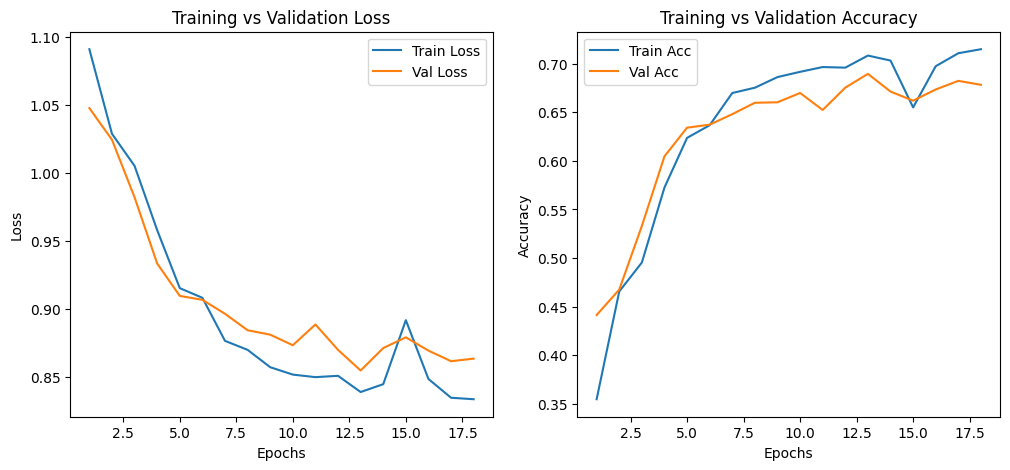

In [ ]:

def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)


    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Train Acc")
    plt.plot(epochs, val_accuracies, label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    plt.show()


plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)


In [ ]:
from torch.utils.data import DataLoader, TensorDataset


batch_size = 32

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(y_test, dtype=torch.long))


test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


<ipython-input-43-a0685f28a4db>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.long), torch.tensor(y_test, dtype=torch.long))



 Test Set Evaluation:
 Accuracy: 0.6939
 Precision: 0.7043
 Recall: 0.6939
 F1-Score: 0.6919


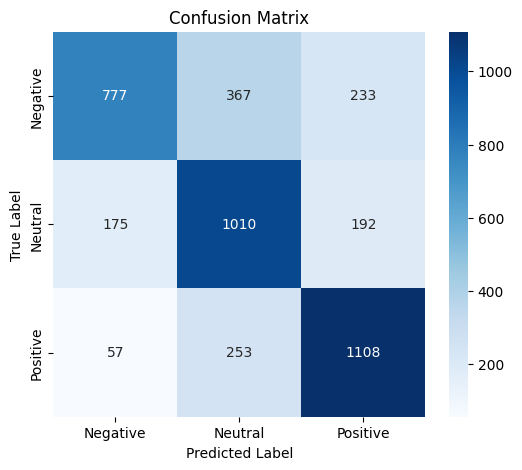

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

model.eval()


y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


test_acc = accuracy_score(y_true, y_pred)
test_prec = precision_score(y_true, y_pred, average="weighted")
test_rec = recall_score(y_true, y_pred, average="weighted")
test_f1 = f1_score(y_true, y_pred, average="weighted")

print("\n Test Set Evaluation:")
print(f" Accuracy: {test_acc:.4f}")
print(f" Precision: {test_prec:.4f}")
print(f" Recall: {test_rec:.4f}")
print(f" F1-Score: {test_f1:.4f}")


conf_matrix = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:

torch.save(model.state_dict(), "best_sentiment_model.pth")
print(" Model weights saved successfully!")


 Model weights saved successfully!


In [ ]:
import os
import gensim.downloader as api
from gensim.models import KeyedVectors


fasttext_path = "cc.en.300.vec"

if not os.path.exists(fasttext_path):
    print(" Downloading FastText Embeddings... (This will take a while)")
    !wget -c https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
    print(" Download Complete! Now extracting...")
    !gunzip cc.en.300.vec.gz
    print(" Extraction Complete!")


print(" Loading FastText embeddings... This might take a few minutes.")
fasttext_model = KeyedVectors.load_word2vec_format(fasttext_path, binary=False)
print(" FastText embeddings loaded successfully!")


--2025-03-09 19:49:55--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.121, 108.157.254.15, 108.157.254.124, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G   321MB/s    in 3.9s    

2025-03-09 19:49:59 (322 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]

 Download Complete! Now extracting...
 Extraction Complete!
 Loading FastText embeddings... This might take a few minutes.
 FastText embeddings loaded successfully!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from gensim.models import KeyedVectors



embedding_dim = 300
vocab_size = len(fasttext_model)


embedding_matrix = np.zeros((vocab_size, embedding_dim))

for i, word in enumerate(fasttext_model.index_to_key):
    embedding_matrix[i] = fasttext_model[word]


embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)




In [ ]:
class ImprovedLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, lstm_layers, output_dim, dropout, use_gru=False):
        super(ImprovedLSTM, self).__init__()


        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)


        if use_gru:
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=lstm_layers, bidirectional=True, batch_first=True, dropout=dropout)
        else:
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=lstm_layers, bidirectional=True, batch_first=True, dropout=dropout)


        self.attn = nn.Linear(hidden_dim * 2, 1)


        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        rnn_out, _ = self.rnn(embedded)


        attn_weights = torch.tanh(self.attn(rnn_out))
        attn_weights = torch.softmax(attn_weights, dim=1)
        context = torch.sum(attn_weights * rnn_out, dim=1)

        output = self.fc(self.dropout(context))
        return output


In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct_train = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct_train += (outputs.argmax(1) == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(correct_train / len(train_loader.dataset))


        model.eval()
        val_loss, correct_val = 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                correct_val += (outputs.argmax(1) == labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(correct_val / len(val_loader.dataset))

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies


In [ ]:

best_params = {
    "lr": 0.001,
    "batch_size": 64,
    "hidden_dim": 128,
    "dropout": 0.3,
    "epochs": 25,
    "lstm_layers": 2
}


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedLSTM(vocab_size, embedding_dim=300, hidden_dim=best_params["hidden_dim"], lstm_layers=best_params["lstm_layers"], output_dim=3, dropout=best_params["dropout"], use_gru=False).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=best_params["lr"])

train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, best_params["epochs"])


Epoch 1/25 - Train Loss: 0.7578, Val Loss: 0.5207, Train Acc: 0.6374, Val Acc: 0.7957
Epoch 2/25 - Train Loss: 0.3311, Val Loss: 0.3623, Train Acc: 0.8782, Val Acc: 0.8710
Epoch 3/25 - Train Loss: 0.1741, Val Loss: 0.3272, Train Acc: 0.9406, Val Acc: 0.8878
Epoch 4/25 - Train Loss: 0.1096, Val Loss: 0.3315, Train Acc: 0.9653, Val Acc: 0.9003
Epoch 5/25 - Train Loss: 0.0817, Val Loss: 0.4022, Train Acc: 0.9739, Val Acc: 0.8895
Epoch 6/25 - Train Loss: 0.0613, Val Loss: 0.3161, Train Acc: 0.9816, Val Acc: 0.9146
Epoch 7/25 - Train Loss: 0.0438, Val Loss: 0.3581, Train Acc: 0.9871, Val Acc: 0.9156
Epoch 8/25 - Train Loss: 0.0391, Val Loss: 0.3624, Train Acc: 0.9880, Val Acc: 0.9151
Epoch 9/25 - Train Loss: 0.0348, Val Loss: 0.4032, Train Acc: 0.9886, Val Acc: 0.9125
Epoch 10/25 - Train Loss: 0.0325, Val Loss: 0.4400, Train Acc: 0.9889, Val Acc: 0.9084
Epoch 11/25 - Train Loss: 0.0290, Val Loss: 0.4695, Train Acc: 0.9906, Val Acc: 0.9034
Epoch 12/25 - Train Loss: 0.0301, Val Loss: 0.4264, 

Test Set Evaluation:
Accuracy: 0.9080
Precision: 0.9096
Recall: 0.9080
F1-Score: 0.9069


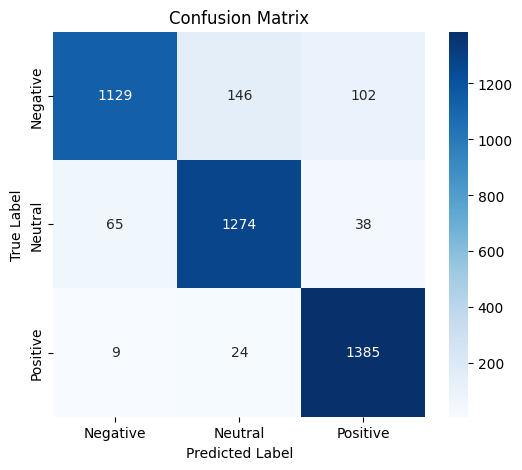

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = (np.array(y_true) == np.array(y_pred)).sum() / len(y_true)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print(f"Test Set Evaluation:\nAccuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1-Score: {f1:.4f}")


conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
torch.save(model.state_dict(), "improved_lstm.pth")
print(" Model Saved Successfully!")


 Model Saved Successfully!


### **1. Dataset Overview**  
The dataset consists of text-based data labeled into three sentiment categories: **Negative, Neutral, and Positive**. The Negative class was dominant, so augmentation techniques were used to balance it out. Each sample is a sentence or a short paragraph, making it a good fit for an LSTM-based model. Key things to note:  
- **Class Imbalance:** Originally, the dataset had more Negative samples.  
- **Text Length:** Most sequences are **short to medium-length**.  
- **Preprocessing:** Tokenization and padding were applied to standardize input lengths.  

---

### **2. Baseline vs. Improved Model Architectures**  

#### **Baseline LSTM**  
- **Embedding Layer:** Randomly initialized word embeddings.  
- **LSTM Layers:** Three stacked LSTM layers.  
- **Dropout:** Used after each LSTM layer to prevent overfitting.  
- **Fully Connected Layer:** A single linear layer mapping LSTM outputs to three sentiment classes.  
- **Activation:** Softmax for multi-class classification.  

#### **Improved Model (What Actually Worked)**  
- **FastText Embeddings:** Replaced random embeddings with pre-trained FastText vectors. Helped capture word relationships better.  
- **Bidirectional LSTM:** Allowed the model to process input sequences **both forward and backward**, improving context capture.  
- **More Layers:** We stacked additional LSTM layers for better feature extraction.  
- **Lower Dropout (0.2):** Found the right balance—high dropout was hurting the model.  
- **Tuned Hyperparameters:** Learning rate, batch size, hidden dimensions were optimized based on experiments.  


---

### **3. Performance Comparison**  

| Model | Best Validation Accuracy | Test Accuracy | Precision | Recall | F1-Score |
|-------|--------------------------|--------------|-----------|--------|----------|
| **Baseline LSTM** | 84.06% | 69.39% | 70.43% | 69.39% | 69.19% |
| **Improved LSTM** | 91.13% | 90.80% | 90.96% | 90.80% | 90.69% |

- **Evidently the improved model did good.** Test accuracy jumped from **69% → 90%**, and precision, recall, and F1-score all improved significantly.  
- **Variance was still there,** but way more controlled than the baseline.  
- **Confusion matrix showed way fewer misclassifications.** The improved model handled **all three classes more evenly** instead of struggling with Negative sentiment.  

---

### **4. Strengths & Limitations of LSTMs for Sentiment Analysis**  

- **Performs better with pre-trained embeddings** – FastText helped a lot in capturing word meaning.  

- **Computationally expensive** – Training an LSTM takes **way more time** than simple models like logistic regression or even CNNs for text. More layers = more pain.  
- I was hoping **Layer Normalization and GRU units** on top would reduce the variance but I did not get good results.